In [28]:
from covid_US import build_dynamic_network, find_clique_edges, SIR_model
import networkx as nx

import matplotlib
from matplotlib import pyplot as plt
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence
from networkx.drawing.nx_pylab import draw_networkx

import numpy as np
import glob
import pickle
import pandas as pd

In [2]:
matplotlib.rcParams["figure.figsize"] = [12, 10]

----------

#### network model parameters

- `social_dist_range`: time frame, within which social distancing restrictions are in effect
- `small_ent_range`: time frame, within which small enterprises are closed
- `large_ent_range`: time frame, within which large enterprises are closed


- `g`: static scale-free network to start from
- `number_of_iterations`: observed time frame
- `contact_duration`: all non-recurring contacts last this long
- `normal_contacts_lambda`: mean active/all contacts ratio in one iteration (drawn from an exponential distribution)
- `social_dist_contacts_lambda`: mean active/all contacts ratio in one iteration (drawn from an exponential distribution) within social distancing time frame
- `parties_lambda`: mean attendance ratio of parties (drawn from an exponential distribution)
- `contacts_threshold`: determines the max ratio of active contacts in one iteration
- `number_of_families`, `family_size`: number and size of complete subgraphs present during the entire observed time frame
- `small_ent_number`, `small_ent_size`: number and size of complete subgraphs present outside `small_ent_range`
- `large_ent_number`, `large_ent_size`: number and size of complete subgraphs present outside `large_ent_range`

-------------

#### SIR model parameters

- `g`: network to run simulation on
- `inf_0`: initial ratio of infected
- `beta`: transmission rate
- `gamma`: recovery rate

---------------

### build dynamic model

In [3]:
model_ID = "final"

In [4]:
name_dict = {
    i: n.format(model_ID)
    for i, n in enumerate(
        [
            "networks/network_{}",
            "models/model_{}",
            "models/iterations_{}",
            "models/trends_{}",
        ]
    )
}

In [39]:
policies = {
    "no_restriction": (None, None, None),
    "full_restriction": (range(50, 500), range(50, 500), range(50, 500)),
    "temp_restriction": (range(50, 100), range(50, 100), range(50, 100)),
    "only_small_enterprises": (range(50, 500), range(50, 100), range(50, 500)),
    "no_large_enterprises": (range(50, 100), range(50, 100), range(50, 500)),
    "only_large_enterprises": (range(50, 500), range(50, 500), range(50, 100)),
}

----------------

In [6]:
g = nx.barabasi_albert_graph(5000, 20)

In [ ]:
for policy, ranges in policies.items():

    dg = build_dynamic_network(ranges[0], ranges[1], ranges[2], g, number_of_iterations=500)
    pickle.dump(dg, open(f"{name_dict[0]}_{policy}.p", "wb"))

    SIR_results = SIR_model(dg, inf_0=0.01)

    for i, r in enumerate(SIR_results):
        pickle.dump(r, open(f"{name_dict[i + 1]}_{policy}.p", "wb"))

    del SIR_results, i, r, dg

--------------

### visualization

In [9]:
models = np.sort([m for m in glob.glob("models/model*.p") if model_ID in m])
trends = np.sort([t for t in glob.glob("models/trend*.p") if model_ID in t])

In [10]:
models

array(['models/model_final_full_restriction.p',
       'models/model_final_no_large_enterprises.p',
       'models/model_final_no_restriction.p',
       'models/model_final_only_large_enterprises.p',
       'models/model_final_only_small_enterprises.p',
       'models/model_final_temp_restriction.p'], dtype='<U43')

In [11]:
colordic = {0: "lightblue", 1: "red", 2: "orange"}

In [55]:
def plot_results(policy):

    trends = pickle.load(
        open("models/trends_{}_{}.p".format(model_ID, policy), "rb")
    )

    for i, t in enumerate(["Susceptible", "Infected", "Removed"]):

        plt.plot(trends[0]["trends"]["node_count"][i], c=colordic[i], linewidth=3, label=t)

    plt.legend()
    plt.ylim(0, 5000)
    plt.xlim(0, 500)

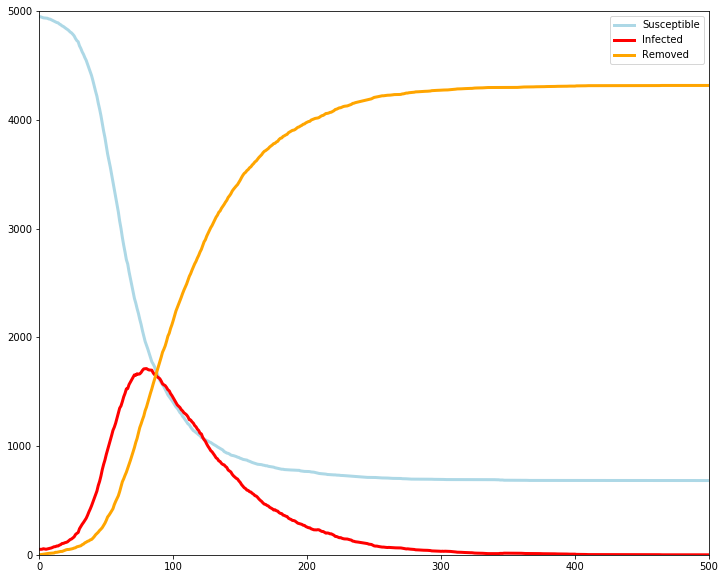

In [56]:
plot_results("no_restriction")

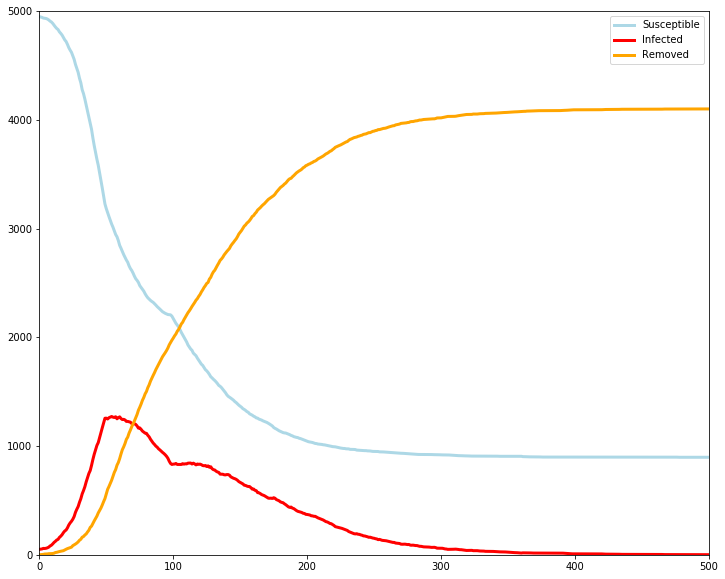

In [57]:
plot_results("temp_restriction")

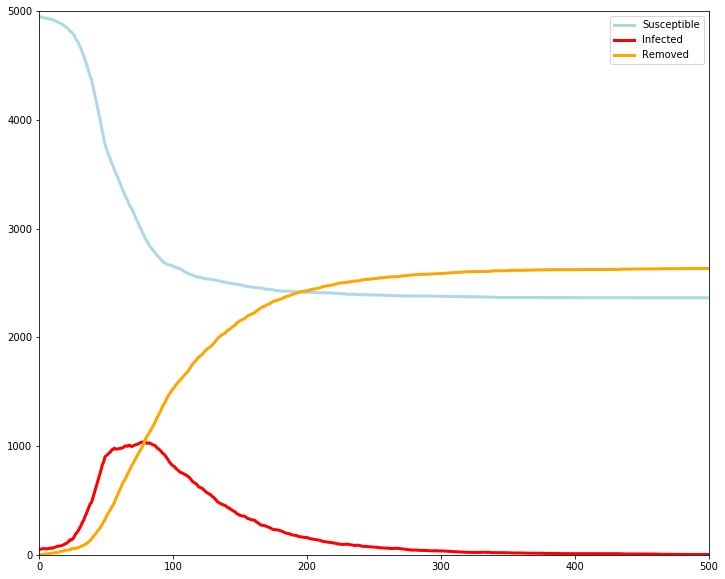

In [58]:
plot_results("only_small_enterprises")

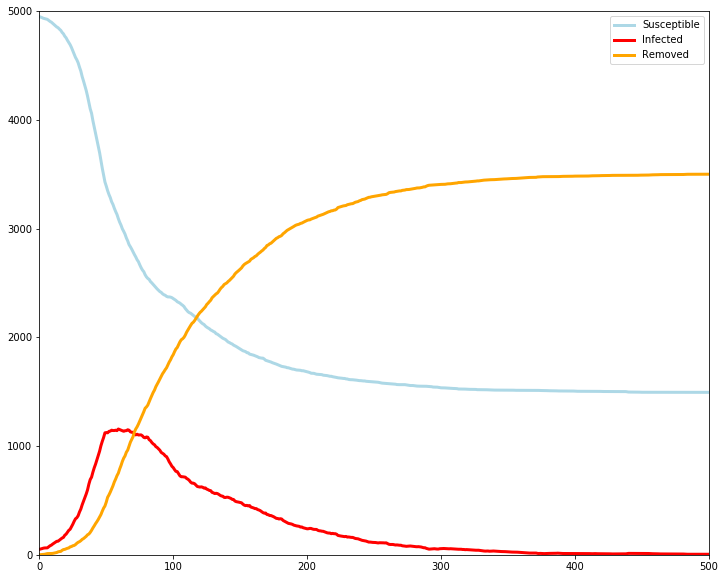

In [59]:
plot_results("no_large_enterprises")

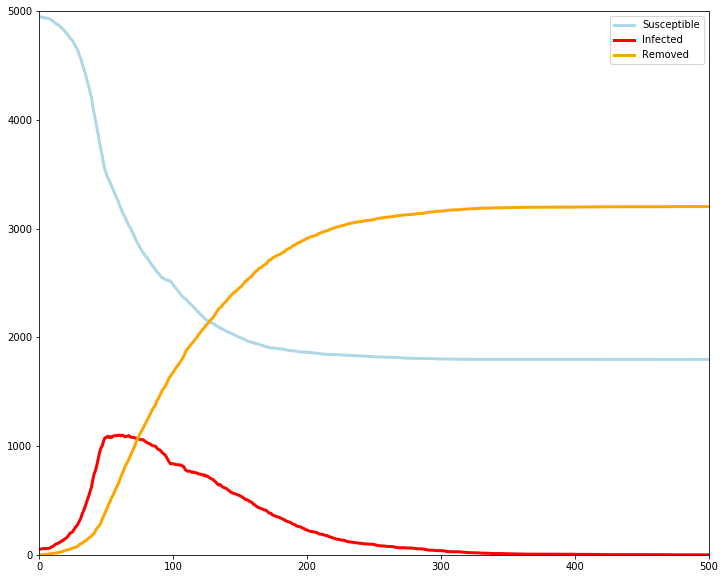

In [60]:
plot_results("only_large_enterprises")

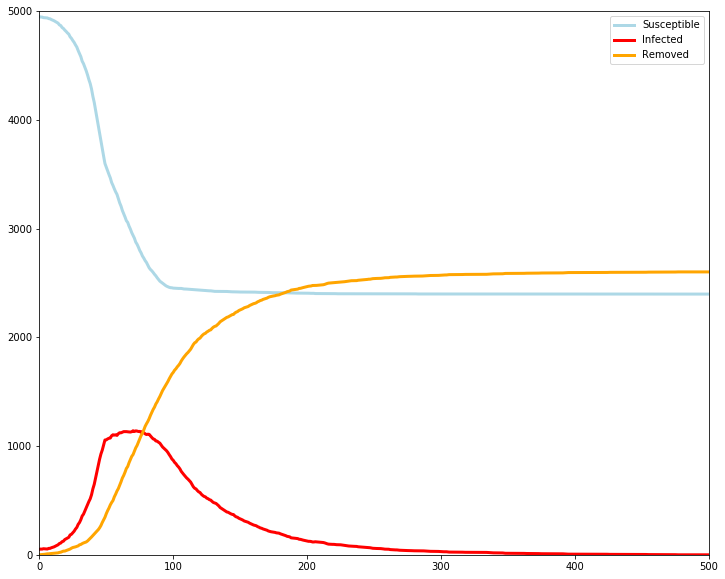

In [61]:
plot_results("full_restriction")

In [48]:
inf_summary = pd.DataFrame(
    {
        p: "{}%".format(max(
            pickle.load(
                open("models/trends_{}_{}.p".format(model_ID, p), "rb"))[0][
                    "trends"
                ]["node_count"][2]
            ) / 50)
        for p in policies.keys()
    }, index=["infected"]
).T.sort_values(by="infected")

In [49]:
inf_summary

,infected
full_restriction,52.04%
only_small_enterprises,52.72%
only_large_enterprises,64.06%
no_large_enterprises,70.06%
temp_restriction,82.06%
no_restriction,86.34%


In [50]:
inf_summary.to_csv("inf_summary.csv")